# Born to slide: mobile origin licensing factors confer resistance to conflicts with RNA polymerase

<img style="float: left;" src="https://icons.iconarchive.com/icons/dan-wiersma/solar-system/48/Mars-icon.png">

## Jupyter notebooks 

#### Figures:
+ S5I
+ S5J

#### Archives:
+ Transcription_licensed-DNA_ATPgS_LS.yama
+ Transcription_licensed-DNA_ATPgS_HS.yama
+ Transcription_low-chromatin-licensed-DNA_ATPgS.yama
+ Transcription_licensed-DNA_T7T_ATPgS.yama

#### Additional data:
+ none

### Initialize ImageJ

In [1]:
import imagej
ij = imagej.init('/Applications/Fiji.app')
ij.getVersion()

'2.1.0/1.53c'

### Imports

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import awesome_data
from marspy.convert.archive import DnaMoleculeArchive, instantiate_archive, describe_archives
from scipy.stats import norm
from tqdm.notebook import tqdm
from functools import reduce

marspy initialized.


### Select archives

In [3]:
selected_archives = ['Transcription_licensed-DNA_ATPgS_LS.yama',
                     'Transcription_licensed-DNA_ATPgS_HS.yama',
                     'Transcription_low-chromatin-licensed-DNA_ATPgS.yama',
                     'Transcription_licensed-DNA_T7T_ATPgS.yama']

### Figure style and output directory

In [4]:
from figure_style import *

In [5]:
set_style_paper()

In [6]:
dir_out = '/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure5/'
dir_out

'/Volumes/pool-duderstadt/Matthias/Manuscript/Figures/SVGs/Figure5/'

### Instantiate selected archives

In [7]:
for archive in tqdm(selected_archives):
    instantiate_archive(archive, awesome_data.datasets)

### Archives Overview

In [8]:
describe_archives(DnaMoleculeArchive.instances)

,# of datasets,# of molecules,labeled proteins,nucleotide,HS challenge?,chromatin,terminator?,archive validation
Transcription_licensed-DNA_ATPgS_LS,1,283,ybbR-LD555-T7; ybbR-LD655-MCM,ATPgS,False,n/a,False,passed
Transcription_licensed-DNA_ATPgS_HS,1,63,ybbR-LD555-T7; ybbR-LD655-MCM,ATPgS,True,n/a,False,passed
Transcription_low-chromatin-licensed-DNA_ATPgS,4,73,SNAP-AF488-T7; LD555-H3-NUC; ybbR-LD655-MCM,ATPgS,False,50x,False,passed
Transcription_licensed-DNA_T7T_ATPgS,2,482,SNAP-AF488-T7; SORT-LD555-ORC; ybbR-LD655-MCM,ATPgS,False,n/a,True,passed


### Load segment tables, apply filter & detect pauses

In [9]:
for index,archive in enumerate(tqdm(DnaMoleculeArchive.instances)):
    
    archive.add_segments_tables()
    archive.filter_segments(b_min=-10, sigma_b_max=10)
    archive.detect_pauses()


### Generate main df

In [10]:
def setup_pandas_df(archive_instances):
    '''
    Sets up a multilevel df with all relevant information
    '''
    
    # indices will be UIDs
    prefixes = set()
    for archive in archive_instances:
        prefixes.update(archive.prefixes)
    col_1 = sorted(list(prefixes))
    #inside
    col_2 = ['initial_intensity', 'lifetime', 'start_site', 'stop_site', 'number_pauses']
    col_3 = ['']
    hier_index = pd.MultiIndex.from_product([col_1,col_2,col_3],names=['molecule','properties','properties_details'])

    return pd.DataFrame(columns=hier_index)
    

In [11]:
df = setup_pandas_df(DnaMoleculeArchive.instances)

# sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)
df.head()


Empty DataFrame
Columns: [(MCM_1_, initial_intensity, ), (MCM_1_, lifetime, ), (MCM_1_, number_pauses, ), (MCM_1_, start_site, ), (MCM_1_, stop_site, ), (MCM_2_, initial_intensity, ), (MCM_2_, lifetime, ), (MCM_2_, number_pauses, ), (MCM_2_, start_site, ), (MCM_2_, stop_site, ), (NUC_1_, initial_intensity, ), (NUC_1_, lifetime, ), (NUC_1_, number_pauses, ), (NUC_1_, start_site, ), (NUC_1_, stop_site, ), (NUC_2_, initial_intensity, ), (NUC_2_, lifetime, ), (NUC_2_, number_pauses, ), (NUC_2_, start_site, ), (NUC_2_, stop_site, ), (NUC_3_, initial_intensity, ), (NUC_3_, lifetime, ), (NUC_3_, number_pauses, ), (NUC_3_, start_site, ), (NUC_3_, stop_site, ), (ORC_1_, initial_intensity, ), (ORC_1_, lifetime, ), (ORC_1_, number_pauses, ), (ORC_1_, start_site, ), (ORC_1_, stop_site, ), (ORC_2_, initial_intensity, ), (ORC_2_, lifetime, ), (ORC_2_, number_pauses, ), (ORC_2_, start_site, ), (ORC_2_, stop_site, ), (T7_1_, initial_intensity, ), (T7_1_, lifetime, ), (T7_1_, number_pauses, ), (T7_1_, start_site, ), (T7_1_, stop_site, )]
Index: []

[0 rows x 40 columns]

In [12]:
# fill dataframe
for archive in tqdm(DnaMoleculeArchive.instances):

    for molecule in archive.molecules:
        #print('handling molecule '+molecule.uid)
        # general columns first
        df.loc[molecule.uid,'dna_length'] = molecule.calc_length_dna()
        df.loc[molecule.uid,'dna_count_valid'] = archive.dna_count_valid
        df.loc[molecule.uid,'hs_wash'] = archive.highsalt_wash
        df.loc[molecule.uid,'nucleotide'] = archive.nucleotide
        df.loc[molecule.uid,'t7_terminator'] = archive.t7_terminator
        df.loc[molecule.uid,'chromatin'] = archive.chromatin
        df.loc[molecule.uid,'tags'] = reduce(lambda tag1,tag2: tag1+','+tag2, molecule.tags)

        # general proteins
        for protein in molecule.proteins:
            #store protein number
            df.loc[molecule.uid,'number_'+protein] = molecule.params['Number_'+protein]
            #assign label for each protein
            df.loc[molecule.uid,'label_'+protein] = archive.labels[protein]
            
            # burst velocity (weighted average, exclude pauses, all regions)
            # always calculate weighted average for all seg_dfs of a protein
            # check if protein has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))) > 0:
                df.loc[molecule.uid,('velocity_'+protein)] = \
                np.average([seg_df.calc_rate()[0] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))],
                           weights=[seg_df.calc_rate()[1] for seg_df in list(filter(lambda seg_df: protein in seg_df.prefix, molecule.seg_dfs))])
        
        # every specific protein
        for prefix in molecule.prefixes:

            #take mean intensity from first 10 frames (maybe need try block later if shorter traces)
            df.loc[molecule.uid,(prefix,'initial_intensity')] = molecule.df.iloc[:10][prefix+'Intensity'].mean()

            #lifetime (in frames) defined on tracking length
            df.loc[molecule.uid,(prefix,'lifetime')] = len(molecule.df[prefix+'y'].dropna())
            
            #start & stop site
            if re.match('T7',prefix):
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df[prefix+'Position_on_DNA'].min()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()
            else:
                df.loc[molecule.uid,(prefix,'start_site')] = molecule.df.iloc[:5][prefix+'Position_on_DNA'].mean()
                df.loc[molecule.uid,(prefix,'stop_site')] = molecule.df[prefix+'Position_on_DNA'].max()

            
            #pauses:
            #number of pauses
            #- do not consider first segment (transcription stalling before UTP arrival)
            #- do not consider pauses above 19 kb on DNA (exclude diffraction limit towards end of DNA = 1.5-2kb)
            #- do not consider pauses with less than 20 seconds (x2-x1)
            
            #note: following is split up in multiple lines to avoid long arguments and reusage
            #save as temporal variable (already exclude exclude first segment of each segment table (index 0 stays in concatenated))
            # check if protein prefix has a SegmentsTable, otherwise skip
            if len(list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))) > 0:
                _seg_df = pd.concat([seg_df.df for seg_df in list(filter(lambda seg_df: prefix == seg_df.prefix, molecule.seg_dfs))]).drop(0,axis=0)
                # reset index for proper loops by index later
                _seg_df.reset_index(drop=True, inplace=True)
                # filter df based on pause definition (keep all segments which are not a pause for recovery)
                _seg_df = _seg_df[(_seg_df['x2'] - _seg_df['x1'] >= 20) & 
                                  (_seg_df['y2'] < 19000) & (_seg_df['y1'] < 19000) | 
                                  (_seg_df['pause_B'] == False)]
                             
            
                df.loc[molecule.uid,(prefix,'number_pauses')] = _seg_df['pause_B'].sum()
            
                #loop through filtered _seg_df to get pause details:
                pause_counter = 0
                for row in _seg_df.index:
                    #do we have a pause segment?
                    if _seg_df.loc[row,'pause_B']:
                        pause_counter+=1

                        # pause duration (endtime - starttime: x2-x1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'duration')] = \
                        _seg_df.loc[row,'x2'] - _seg_df.loc[row,'x1']

                        # pause position on dna (mean of start and end: y2-y1)
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'position_on_dna')] = \
                        (_seg_df.loc[row,'y2'] + _seg_df.loc[row,'y1']) / 2

                        # does it recover from pause (=> is it the last segment)
                        # note: concatenated df is perfect because subsequent region can show pause recovery
                        df.loc[molecule.uid,(prefix,'pause_'+str(pause_counter),'recovery')] = \
                        row != _seg_df.index.max()

                # sanity check between pause_counter and earlier detected pauses
                # [0] necessary because of multi-index. use .xs() alternatively
                if pause_counter != df.loc[molecule.uid,(prefix,'number_pauses')][0]:
                    print(f"Attention! Problem with pause detection in molecule {molecule.uid}.")
                    
# fill all NaN values in number_protein with 0
proteins = set()
for archive in DnaMoleculeArchive.instances:
    proteins.update(archive.proteins)

for protein in proteins:
    df['number_'+protein] = df['number_'+protein].apply(lambda value: 0 if np.isnan(value) else value)
    
# convert tags back to list
df['tags'] = df['tags'].apply(lambda tags: tags.split(','))

# again sort MultiIndexCols for performance
df.sort_index(axis=1, inplace=True)

# fix data types
df = df.infer_objects()


/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/Users/matze/anaconda3/envs/scijava/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [13]:
df.head()

molecule                          MCM_1_                                  \
properties             initial_intensity lifetime number_pauses  pause_1   
properties_details                                              duration   
ieQwV6aDnrXypabArn9wxK          32524.85    200.0           0.0      NaN   
6WWUeuYF81fiqUQ1eBop1m               NaN      NaN           NaN      NaN   
ntzohE8juHpTgESMDENF9T          15408.55    138.0           0.0      NaN   
tPDHFmGT4FCZfu4oWkxLYQ          13769.90    145.0           0.0      NaN   
njwaKPQkSS9K6UFxLBKNGC               NaN      NaN           NaN      NaN   

molecule                                                                  \
properties                                       pause_2                   
properties_details     position_on_dna recovery duration position_on_dna   
ieQwV6aDnrXypabArn9wxK             NaN      NaN      NaN             NaN   
6WWUeuYF81fiqUQ1eBop1m             NaN      NaN      NaN             NaN   
ntzohE8juHpTgESMDENF9T             NaN      NaN      NaN             NaN   
tPDHFmGT4FCZfu4oWkxLYQ             NaN      NaN      NaN             NaN   
njwaKPQkSS9K6UFxLBKNGC             NaN      NaN      NaN             NaN   

molecule                                  ... number_MCM number_NUC  \
properties                       pause_3  ...                         
properties_details     recovery duration  ...                         
ieQwV6aDnrXypabArn9wxK      NaN      NaN  ...        1.0        0.0   
6WWUeuYF81fiqUQ1eBop1m      NaN      NaN  ...        0.0        0.0   
ntzohE8juHpTgESMDENF9T      NaN      NaN  ...        1.0        0.0   
tPDHFmGT4FCZfu4oWkxLYQ      NaN      NaN  ...        2.0        0.0   
njwaKPQkSS9K6UFxLBKNGC      NaN      NaN  ...        0.0        0.0   

molecule               number_ORC number_T7 t7_terminator  \
properties                                                  
properties_details                                          
ieQwV6aDnrXypabArn9wxK        0.0       1.0         False   
6WWUeuYF81fiqUQ1eBop1m        0.0       1.0         False   
ntzohE8juHpTgESMDENF9T        0.0       1.0         False   
tPDHFmGT4FCZfu4oWkxLYQ        0.0       1.0         False   
njwaKPQkSS9K6UFxLBKNGC        0.0       1.0         False   

molecule                                           tags velocity_MCM  \
properties                                                             
properties_details                                                     
ieQwV6aDnrXypabArn9wxK   [accept, coll_T7_1_MCM_1_push]    28.510461   
6WWUeuYF81fiqUQ1eBop1m                         [accept]          NaN   
ntzohE8juHpTgESMDENF9T  [accept, coloc_T7_1_MCM_1_push]    25.151466   
tPDHFmGT4FCZfu4oWkxLYQ  [accept, coloc_T7_1_MCM_1_push]    26.594233   
njwaKPQkSS9K6UFxLBKNGC                         [accept]          NaN   

molecule               velocity_NUC velocity_ORC velocity_T7  
properties                                                    
properties_details                                            
ieQwV6aDnrXypabArn9wxK          NaN          NaN   28.827112  
6WWUeuYF81fiqUQ1eBop1m          NaN          NaN   29.406737  
ntzohE8juHpTgESMDENF9T          NaN          NaN   23.615243  
tPDHFmGT4FCZfu4oWkxLYQ          NaN          NaN   26.013924  
njwaKPQkSS9K6UFxLBKNGC          NaN          NaN   29.353389  

[5 rows x 83 columns]

## Figures

### Figure S5I: Collision outcome pushed OCCM with Nucleosomes

In [14]:
# correlate collision outcome with NUC intensity
df_coll = pd.DataFrame(columns=['initial_intensity','coll_outcome'])

# loop through all archives with chromatin low (50x) and high (75x)
for archive in filter(lambda archive: archive.chromatin in {'50x','75x'},DnaMoleculeArchive.instances):
    for molecule in archive.molecules:
        # check for potential collision with each nucleosome
        intensity = 0
        for i in range(1,molecule.proteins['NUC']+1):
            collision = False
            for tag in molecule.tags:
                if re.match('coll_MCM_1_NUC_'+str(i)+'_',tag):
                    collision = True
                    outcome = tag.split('coll_MCM_1_NUC_'+str(i)+'_')[-1]
            if collision:
                # NUC intensity
                intensity += molecule.df.iloc[:5]['NUC_'+str(i)+'_Intensity'].mean()

                _temp_df = pd.DataFrame(data=[[intensity,outcome]],columns=['initial_intensity','coll_outcome'])
                df_coll = pd.concat([df_coll,_temp_df])

                # actions depending on different outcomes
                # reset intensity to 0 in case NUC was ejected and not pushed
                # note T7eject & stall won't lead to subsequent collisions

                # MCM ejected or stall => skip other nucleosomes
                if re.search('MCMeject',outcome) or re.search('stall',outcome):
                    break
                # NUC ejected => go back to previous intensity
                elif re.search('NUCeject',outcome):
                    # subtract added intensity for subsequent collisions
                    intensity -= molecule.df.iloc[:5]['NUC_'+str(i)+'_Intensity'].mean()
                else:
                    # push and pause
                    continue
            
        

In [15]:
df_coll.head()

,initial_intensity,coll_outcome
0,52486.7,push
0,65774.1,push
0,76518.6,MCMeject
0,47250.4,push
0,103221.5,push


In [16]:
# 1 LD555 has around 35000 intensity, but labeling is 150 % only
# intensity cutoffs estimated with bernoulli probabilities
def estimate_bleaching(intensity):
    if intensity == 0:
        return '0'
    else:
        return '>=1'

In [17]:
df_coll['number_NUC'] = df_coll['initial_intensity'].apply(estimate_bleaching)
df_coll.head()

,initial_intensity,coll_outcome,number_NUC
0,52486.7,push,>=1
0,65774.1,push,>=1
0,76518.6,MCMeject,>=1
0,47250.4,push,>=1
0,103221.5,push,>=1


In [18]:
df_coll.groupby('number_NUC').describe()

initial_intensity                                                \
                       count          mean           std      min      25%   
number_NUC                                                                   
>=1                     41.0  62360.002439  37757.690311  21409.6  33843.8   

                                        
                50%      75%       max  
number_NUC                              
>=1         52306.4  72046.9  191012.5

In [19]:
# concatenate nuc counts for both chromatin & valid dna counts
temp_df = pd.concat([pd.DataFrame(data=[df_coll[(df_coll['number_NUC']==number_nuc)]['coll_outcome'].value_counts()
                                        for number_nuc in df_coll['number_NUC'].unique()])],axis=0).T
temp_df.columns = [number_nuc for number_nuc in df_coll['number_NUC'].unique()]
temp_df

,>=1
push,15
stall,12
MCMeject,5
pause,5
NUCeject,2
MCMeject-NUCeject,2


In [20]:
df_coll = temp_df.copy()
del(temp_df)

In [21]:
#order
df_coll = df_coll.reindex(['push', 'NUCeject','pause', 'stall', 'MCMeject', 'MCMeject-NUCeject'])
df_coll

,>=1
push,15
NUCeject,2
pause,5
stall,12
MCMeject,5
MCMeject-NUCeject,2


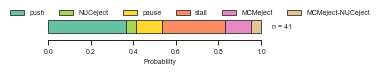

In [22]:
#plot a stacked barplot
fig,axes = plt.subplots(figsize=(4,0.5))

(df_coll/df_coll.sum()).T.plot(kind='barh',stacked=True,ax=axes,rot=0,edgecolor='.15',
                               color=[palettes['qualitative'][0],palettes['qualitative'][4],
                                      palettes['qualitative'][5],palettes['qualitative'][1],
                                      palettes['qualitative'][3],palettes['qualitative'][6]])
axes.set_xlabel("Probability")

#axes.set_title("Fate upon T7RNAP-MCM collision")
axes.set_xlim([0,1.05])
axes.set_yticks([])

labels = [int(df_coll.sum()[col]) for col in df_coll.columns]

#calculate y offset to label bars on top

rects = axes.patches
counter = 0
for rect, label in zip(rects, labels):
    axes.text(1.05, rect.get_y() + rect.get_height()/2, s=f'n = {label}', ha='left', va='center')
    counter+=1
axes.legend(ncol=len(df.index),bbox_to_anchor=[-0.2, 1], loc='center left',frameon=False)

#tidy up
#fig.tight_layout()
sns.despine(trim=True,left=True)
#save
plt.savefig(dir_out+'S5I_OCCM-NUC_collision_fate.svg',transparent=True)

### Figure S5J: OCCM rate +/- pushed NUC

In [23]:
df_push = pd.DataFrame(columns=['initial_intensity','velocity'])

# loop through all archives with chromatin low (50x) and high (75x)
for archive in DnaMoleculeArchive.instances:
#for archive in [archive0,archive1,archive4,archive5]:
    # loop through all molecules
    for molecule in archive.molecules:
        valid = True
        
        # only with 1 MCM (usually at ARS1)
        if molecule.proteins['MCM'] != 1:
            continue
            
        valid = True
                
        for protein, number in molecule.proteins.items():
            # make sure molecule only contains NUC & T7 
            if (number > 0 and protein not in {'T7', 'NUC', 'MCM'}):
                valid = False
                continue
            # more than 1 T7 (just a sanity check, shouldn't happen)
            elif number > 1 and protein not in {'NUC', 'MCM'}:
                valid = False
                continue
                
        # loop through all seg_dfs with MCM in prefix
        if valid:
            for seg_df in filter(lambda seg_df: 'MCM' in seg_df.prefix, molecule.seg_dfs):
                # get the rate
                velocity = seg_df.calc_rate()[0]

                # get intensity_NUC
                intensity = 0
                # add intensities for all pushed NUCs
                for i in range(1,seg_df.pushed_proteins['NUC']+1):
                    intensity += molecule.df.iloc[:5]['NUC_'+str(i)+'_Intensity'].mean()

                _temp_df = pd.DataFrame(data=[[intensity,velocity]],
                                        columns=['initial_intensity','velocity'])
                df_push = pd.concat([df_push,_temp_df])
                
                
df_push = df_push.convert_dtypes()
df_push = df_push.dropna()
df_push

,initial_intensity,velocity
0,0.0,28.510461
0,0.0,25.151466
0,0.0,24.959519
0,0.0,23.321321
0,0.0,26.539915
...,...,...
0,0.0,25.599435
0,0.0,27.189317
0,0.0,26.751140
0,0.0,23.249546


In [24]:
df_push.corr()

,initial_intensity,velocity
initial_intensity,1.000000,0.235507
velocity,0.235507,1.000000


In [25]:
df_push['number_NUC'] = df_push['initial_intensity'].apply(estimate_bleaching)

In [26]:
df_push.groupby('number_NUC').describe()

initial_intensity                                               \
                       count         mean           std      min      25%   
number_NUC                                                                  
0                      149.0      0.00000      0.000000      0.0      0.0   
>=1                     21.0  58906.67619  26619.538298  21409.6  38629.0   

                                       velocity                       \
                50%      75%       max    count       mean       std   
number_NUC                                                             
0               0.0      0.0       0.0    149.0  26.355740  3.559986   
>=1         49894.6  68947.8  103873.3     21.0  29.182257  4.582028   

                                                                   
                  min        25%        50%        75%        max  
number_NUC                                                         
0           16.454647  24.334216  26.747900  28.723819  35.698177  
>=1         17.569554  27.407782  28.680909  32.257286  38.911640

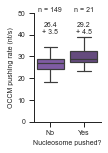

In [27]:
# Observed rates +/- NUC
protein = 'MCM_NUC'
fig,axes = plt.subplots(figsize=(1.2, 2))

sns.boxplot(x='number_NUC',y='velocity',data=df_push,order=sorted(df_push['number_NUC'].unique()),
            palette=palettes[protein][::2],fliersize=0)


#calculate number of observations
nobs = df_push['number_NUC'].value_counts().sort_index()
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

#put nobs into plot

pos = range(len(nobs))

for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 50, nobs[tick],
    horizontalalignment='center',verticalalignment='bottom')
    
rates = []
# fit data to normal distribution and print on plot
for num_nuc in sorted(df_push['number_NUC'].unique()):
    mu, std = norm.fit(df_push[df_push['number_NUC']==num_nuc]['velocity'])
    rates.append(f'{round(mu,1)}\n+ {round(std,1)}')
    
for tick,label in zip(pos,axes.get_xticklabels()):
    axes.text(pos[tick], 40, rates[tick],
    horizontalalignment='center',verticalalignment='bottom')

axes.set_ylim(0,50)
axes.set_xlabel('Nucleosome pushed?')
axes.set_ylabel('OCCM pushing rate (nt/s)')
axes.set_xticklabels(['No','Yes'])
# axes.set_title('T7 RNAP can push trains of MCM DHs')

sns.despine()
#plt.tight_layout()

plt.savefig(dir_out+'S5J_OCCM_rates_vs_#NUC.svg',transparent=True)